# EMISSOR chat bot with audio backend

### UNDER CONSTRUCTION

This notebook tests the backend api to communicate with the naoqi server installed on the pepper robot. It also calls the ASR (automatic speech recognition) and VAD (voice activity detection) modules.

## Running with ASR

In [3]:
import requests
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from cltl.asr.speechbrain_asr import SpeechbrainASR
from cltl.asr.wav2vec_asr import Wav2Vec2ASR
from cltl.backend.api.camera import CameraResolution 
from cltl.backend.source.pyaudio_source import PyAudioSource
from cltl.backend.source.cv2_source import SystemImageSource
from cltl.backend.source.client_source import ClientAudioSource, ClientImageSource
from cltl.vad.webrtc_vad import WebRtcVAD

from cltl.backend.api.util import raw_frames_to_np

In [4]:
run_remote = True

audio_source = ClientAudioSource("http://192.168.1.176:8000/audio") if run_remote else PyAudioSource(16000, 1, 480)
image_source = ClientImageSource("http://192.168.1.176:8000/video") if run_remote else SystemImageSource(CameraResolution.QVGA)


# Add a `storage` directory to store audio files to VAD or ASR for debugging
vad = WebRtcVAD(allow_gap=250, padding=5, storage="./audio")
asr=Wav2Vec2ASR("jonatasgrosman/wav2vec2-large-xlsr-53-english", 16000, storage="./audio")
# asr = SpeechbrainASR(model_id="speechbrain/asr-transformer-transformerlm-librispeech", sampling_rate=16000, storage="./audio")

    
def detect_and_transcribe():
    text = ""
    image = None
    with audio_source as audio:
        frames = raw_frames_to_np(audio, audio_source.frame_size, audio_source.channels, audio_source.depth)

        print("Listening")
        speech, offset, consumed = tuple(vad.detect_vad(frames, audio_source.rate))
        print("Voice activity detected")

        text = asr.speech_to_text(np.concatenate(tuple(speech)), audio_source.rate)
        
    with image_source as img_src:
        image = img_src.capture()


    return text, image

In [8]:
for _ in range(5):
    print("Please talk to calibrate Voice Activity Detection")
    try:
        detect_and_transcribe()
    except Exception as e:
        print("Failed", e)

print("Calibrated VAD")

Please talk to calibrate Voice Activity Detection
Listening
Voice activity detected
Please talk to calibrate Voice Activity Detection
Listening
Voice activity detected
Please talk to calibrate Voice Activity Detection
Listening
Voice activity detected
Please talk to calibrate Voice Activity Detection
Listening
Voice activity detected
Please talk to calibrate Voice Activity Detection
Listening
Voice activity detected
Calibrated VAD


Listening
Voice activity detected
Detected text: WHELLE WE HAVEE BE
Captured image: (240, 320, 3)


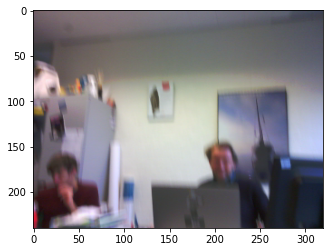

Listening
Voice activity detected
Detected text: YES
Captured image: (240, 320, 3)


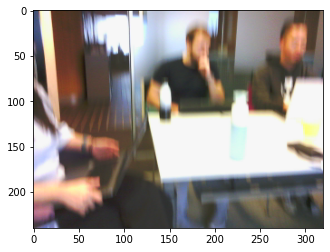

Listening
Voice activity detected
Detected text: DON'T NO WHATAPAS A FEW HAR FLOTIBLE PEOPLE COLLECTING TWITS
Captured image: (240, 320, 3)


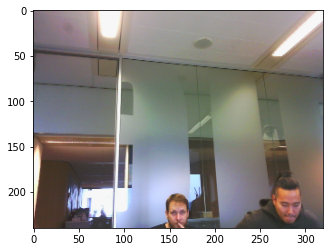

Listening
Voice activity detected
Detected text: YOU KNOW NESE
Captured image: (240, 320, 3)


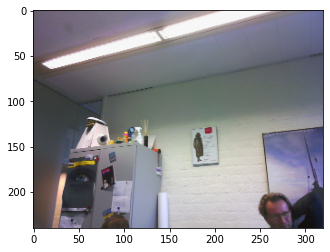

Listening
Voice activity detected
Detected text: ES
Captured image: (240, 320, 3)


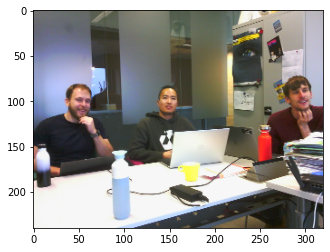

Listening
Voice activity detected
Detected text: TOCOPERO DATAS ISIMULTIPLE PEOPLE ALISINIWITI TEN
Captured image: (240, 320, 3)


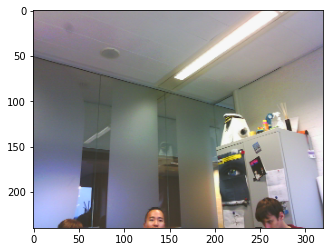

Listening
Voice activity detected
Detected text: SAY STOP
Captured image: (240, 320, 3)


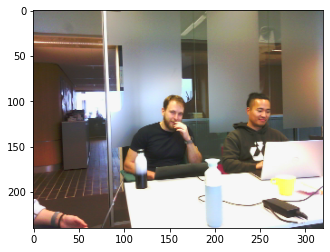

Listening
Voice activity detected
Detected text: TS NO
Captured image: (240, 320, 3)


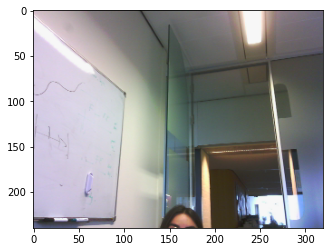

Listening
Voice activity detected
Detected text: MY SISTER
Captured image: (240, 320, 3)


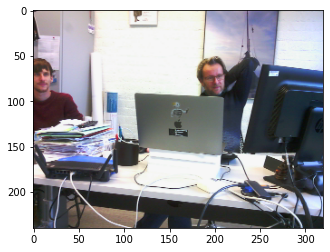

Listening
Voice activity detected
Detected text: NOGHS
Captured image: (240, 320, 3)


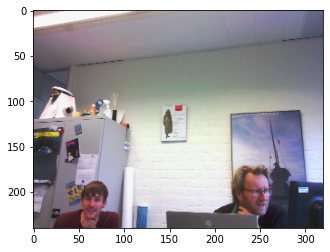

Listening
Voice activity detected
Detected text: 
Captured image: (240, 320, 3)


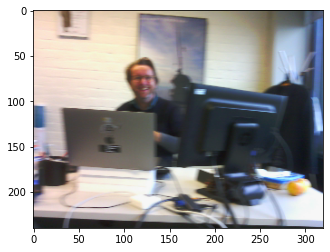

Listening
Voice activity detected
Detected text: O NOUGH I ONLY TO STAR JUST I REMEMBER
Captured image: (240, 320, 3)


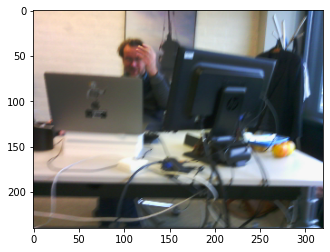

Listening
Voice activity detected
Detected text: MAYBE IMAGE BECAMES FROCLASNICLY JE WISH UNHER
Captured image: (240, 320, 3)


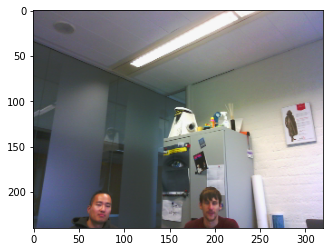

Listening
Voice activity detected
Detected text: YEA TRANSLATED INTO TRIPLESSOWARANG'S PUARAMD'S WONDERING ABOUT AT THESE WORDS LKE FLAULUBLE AND PROGRAMICALLY  HEARS HIS WORDS WHICH ARE LIKE SO LOW FREQUENT
Captured image: (240, 320, 3)


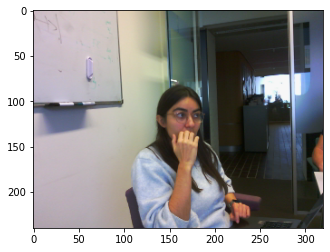

Listening
Voice activity detected
Detected text: YOU'RE BOT A LOT OF WORDS
Captured image: (240, 320, 3)


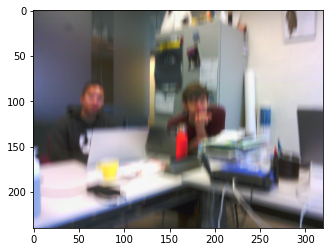

Listening
Voice activity detected
Detected text: SERUS THO MUST BAKA STOP
Captured image: (240, 320, 3)


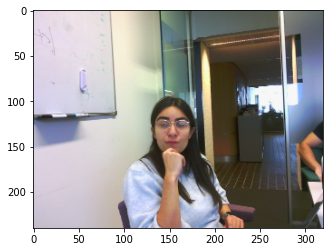

Listening
Voice activity detected
Detected text: TOH
Captured image: (240, 320, 3)


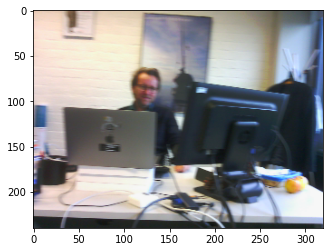

Listening
Voice activity detected


KeyboardInterrupt: 

In [24]:
tts_headers = {'Content-type': 'text/plain'}

text = ""
while not text.lower()=="stop":
    try:
        text, image = detect_and_transcribe()
        print("Detected text:", text)
        
        print("Captured image:", image.image.shape)
        plt.imshow(image.image)
        plt.show()
        
        if run_remote:
            requests.post("http://192.168.1.176:8000/text", data=f"Did you say {text}?", headers=tts_headers)
    except Exception as e:
        print("Failed", e)
        raise e

In [25]:
import requests
tts_headers = {'Content-type': 'text/plain'}
animation = CRAZY
for _ in range(2):
    #\\^startTag({1}){0}^stopTag({1})
    response = '\\^startTag(crazy)Hello strangers?^stopTag(crazy)'
    requests.post("http://192.168.1.176:8000/text", data=response, headers=tts_headers)
    #requests.post("http://192.168.1.176:8000/text", data="Hello stranger!", headers=tts_headers)

## Animations installed on Pepper

Taken from "animations.py", pepper3

In [2]:
ABOVE = "above"
AFFIRMATIVE = "affirmative"
AFFORD = "afford"
AGITATED = "agitated"
ALL = "all"
ALLRIGHT = "allright"
ALRIGHT = "alright"
ANY = "any"
APPEASE = "appease"
ASHAMED = "ashamed"
ASSUAGE = "assuage"
ATTEMPER = "attemper"
BACK = "back"
BASHFUL = "bashful"
BECALM = "becalm"
BEG = "beg"
BESEECH = "beseech"
BLANK = "blank"
BODY_LANGUAGE = "body_language"
BORED = "bored"
BOW = "bow"
BUT = "but"
CALL = "call"
CALM = "calm"
CHOICE = "choice"
CHOOSE = "choose"
CLEAR = "clear"
CLOUD = "cloud"
COGITATE = "cogitate"
COOL = "cool"
CRAZY = "crazy"
DESPAIRING = "despairing"
DESPERATE = "desperate"
DISAPPOINTED = "disappointed"
DOWN = "down"
EARTH = "earth"
EMBARRASSED = "embarrassed"
EMPTY = "empty"
ENTHUSIASTIC = "enthusiastic"
ENTIRE = "entire"
ENTREAT = "entreat"
ESTIMATE = "estimate"
EVERY = "every"
EVERYONE = "everyone"
EVERYTHING = "everything"
EXALTED = "exalted"
EXCEPT = "except"
EXCITED = "excited"
EXPLAIN = "explain"
FAR = "far"
FIELD = "field"
FLOOR = "floor"
FORLORN = "forlorn"
FRIENDLY = "friendly"
FRONT = "front"
FRUSTRATED = "frustrated"
GENTLE = "gentle"
GIFT = "gift"
GIVE = "give"
GROUND = "ground"
HAPPY = "happy"
HELLO = "hello"
HER = "her"
HERE = "here"
HEY = "hey"
HI = "hi"
HIGH = "high"
HIM = "him"
HOPELESS = "hopeless"
HYSTERICAL = "hysterical"
I = "i"
IMPLORE = "implore"
INDICATE = "indicate"
JOYFUL = "joyful"
ME = "me"
MEDITATE = "meditate"
MODEST = "modest"
MOLLIFY = "mollify"
MY = "my"
MYSELF = "myself"
NEGATIVE = "negative"
NERVOUS = "nervous"
NO = "no"
NOT_KNOW = "not_know"
NOTHING = "nothing"
OFFER = "offer"
OK = "ok"
ONCE_UPON_A_TIME = "once_upon_a_time"
OPPOSE = "oppose"
OR = "or"
PACIFY = "pacify"
PEACEFUL = "peaceful"
PICK = "pick"
PLACATE = "placate"
PLEASE = "please"
PRESENT = "present"
PROFFER = "proffer"
QUIET = "quiet"
RAPTUROUS = "rapturous"
RARING = "raring"
REASON = "reason"
REFUTE = "refute"
REJECT = "reject"
ROUSING = "rousing"
SAD = "sad"
SELECT = "select"
SHAMEFACED = "shamefaced"
SHOW = "show"
SHOW_SKY = "show_sky"
SHY = "shy"
SKY = "sky"
SOOTHE = "soothe"
SUN = "sun"
SUPPLICATE = "supplicate"
TABLET = "tablet"
TALL = "tall"
THEM = "them"
THERE = "there"
THINK = "think"
TIMID = "timid"
TOP = "top"
UNACQUAINTED = "unacquainted"
UNCOMFORTABLE = "uncomfortable"
UNDETERMINED = "undetermined"
UNDISCOVERED = "undiscovered"
UNFAMILIAR = "unfamiliar"
UNKNOWN = "unknown"
UNLESS = "unless"
UP = "up"
UPSTAIRS = "upstairs"
VOID = "void"
WARM = "warm"
WINNER = "winner"
YEAH = "yeah"
YES = "yes"
YOO_HOO = "yoo-hoo"
YOU = "you"
YOUR = "your"
ZERO = "zero"
ZESTFUL = "zestful"